# Lab 18: Regularization (to correct over-fitting)


Regularization is a way to augment the gradient descent process to control the growth of the weights/coefficients. Large weights/coefficients often result in over-fitting. By augmenting the cost functions slightly, we can force gradient descent to control the growth of the coefficients. Lambda (λ) is the factor used to determine how much we control the growth of the weights.
* Lambda choice: A smaller lambda prioritizes the fitting / growth of the weights (risks over-fitting).A larger lambda minimizes the weights (risks under-fitting).
* The cost functions differ significantly between linear and logistic regression, but adding regularization to the equations uses the same process.
* The derivative/slope functions for performaing gradient descent on linear and logistic regression are very similar. They differ only in the implementation of f(x) which is a polynomial sequence in linear regression but it is a sigmoid function in logistical regression.
* NB: The b (intercept) term is never regularized because this does not have a meaningful impact on reducing over-fitting. This means that the derivative with respect to b does not change if you add regularization.

In [5]:
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from plt_overfit import overfit_example, output
from lab_utils_common import sigmoid
np.set_printoptions(precision=8)

## Augment cost function for linear regression to include regularization

In [77]:
def cost_function_linear_regression_regularized(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns:
      total_cost (scalar):  cost 
    """

    m  = X.shape[0] # number of training examples
    n  = len(w)     # number of weights/features

    # FIRST TERM OF COST FUNCTION (FITTING)
    nominal_cost = 0.
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b                               #(n,)(n,)=scalar, see np.dot
        nominal_cost += (f_wb_i - y[i])**2                         #scalar 

    average_nominal_cost = nominal_cost / (2 * m)                  #scalar  

    # SECOND TERM OF COST FUNCTION (CONTROLLING GROWTH OF WEIGHTS)
    regularized_cost = 0
    for j in range(n):
        regularized_cost += (w[j]**2)                              #scalar

    # take the average over all examples AND apply lambda
    average_regularized_cost = (lambda_/(2*m)) * regularized_cost          #scalar

    
    # ADD THE TWO TERMS TOGETHER
    total_cost = average_nominal_cost + average_regularized_cost   #scalar
    
    return total_cost     

In [79]:
# Test the above cost function with random inputs

np.random.seed(1)
X_tmp = np.random.rand(5,6)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1]).reshape(-1,)-0.5
b_tmp = 0.5
lambda_tmp = 0.7
cost_tmp = cost_function_linear_regression_regularized(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print("Regularized cost:", cost_tmp)
# expected value: 0.07917239320214275

Regularized cost: 0.07917239320214275


## Gradient descent for linear regression with regularization

In [81]:
def compute_gradient_linear_regression_regularized(X, y, w, b, lambda_): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)

    # initialize the derivative variables
    dj_dw = np.zeros((n,))
    dj_db = 0.

    # FIRST TERM OF DERIVATIVE (FITTING)
    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   

        # calculate derivative with respect to w
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]     

        # calculate derivative with respect to b
        dj_db = dj_db + err   
        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m   

    # SECOND TERM OF DERIVATIVE (REGULARIZATION)... only applies to derivative with respect to w
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw

In [83]:
# Test the above gradient function

np.random.seed(1)
X_tmp = np.random.rand(5,3)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1])
b_tmp = 0.5
lambda_tmp = 0.7
dj_db_tmp, dj_dw_tmp =  compute_gradient_linear_regression_regularized(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print(f"Regularized dj_dw:\n {dj_dw_tmp.tolist()}", )
print(f"dj_db: {dj_db_tmp}", )

# expected outputs
# Regularized dj_dw: [0.29653214748822276, 0.4911679625918033, 0.21645877535865857]
# dj_db: 0.6648774569425726

Regularized dj_dw:
 [0.29653214748822276, 0.4911679625918033, 0.21645877535865857]
dj_db: 0.6648774569425726


## Gradient descent for logistic regression with regularization

In [87]:
def compute_gradient_logistic_regression_regularized(X, y, w, b, lambda_): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns
      dj_dw (ndarray Shape (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)            : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape                                     #(number of examples, number of features)

    # initialize the derivative variables
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    # FIRST TERM OF DERIVATIVE (FITTING)
    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar; Update f(x) to sigmoid function
        err_i  = f_wb_i  - y[i]                       #scalar

        # calculate derivative with respect to w
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar

        # calculate derivative with respect to b
        dj_db = dj_db + err_i
        
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar

    # SECOND TERM OF DERIVATIVE (REGULARIZATION)... only applies to derivative with respect to w
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw  



# Now that you've updated the gradient descent function, you can run it - just like we did in previous labs - to determine weights and b. 

# The function call will look something like this: 
# w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, 
#                                     compute_cost_regularized, compute_gradient_regularized, 
#                                     alpha, iterations, lambda_)

In [89]:
# Test above gradient function

np.random.seed(1)
X_tmp = np.random.rand(5,3)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1])
b_tmp = 0.5
lambda_tmp = 0.7
dj_db_tmp, dj_dw_tmp =  compute_gradient_logistic_regression_regularized(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print(f"Regularized dj_dw:\n {dj_dw_tmp.tolist()}", )
print(f"dj_db: {dj_db_tmp}", )

# expected values
# Regularized dj_dw:
#  [0.17380012933994293, 0.32007507881566943, 0.10776313396851499]
# dj_db: 0.341798994972791

Regularized dj_dw:
 [0.17380012933994293, 0.32007507881566943, 0.10776313396851499]
dj_db: 0.341798994972791


## Rerun over-fitted example from previous lab

Output()

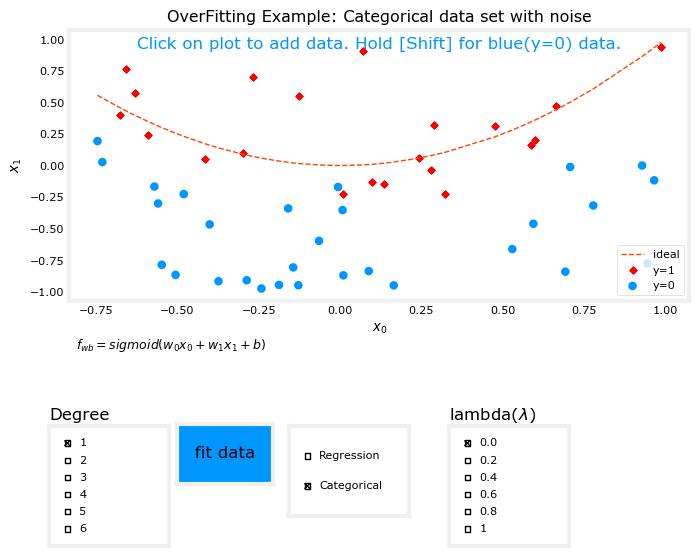

In [91]:
plt.close("all")
display(output)
ofit = overfit_example(True)